In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-cost-dataset/insurance.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor 
import shap 
import gc
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [3]:
df = pd.read_csv("/kaggle/input/medical-insurance-cost-dataset/insurance.csv")

In [4]:
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [8]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [9]:
import inspect

print(inspect.signature(sns.pairplot))

(data, *, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5, aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)


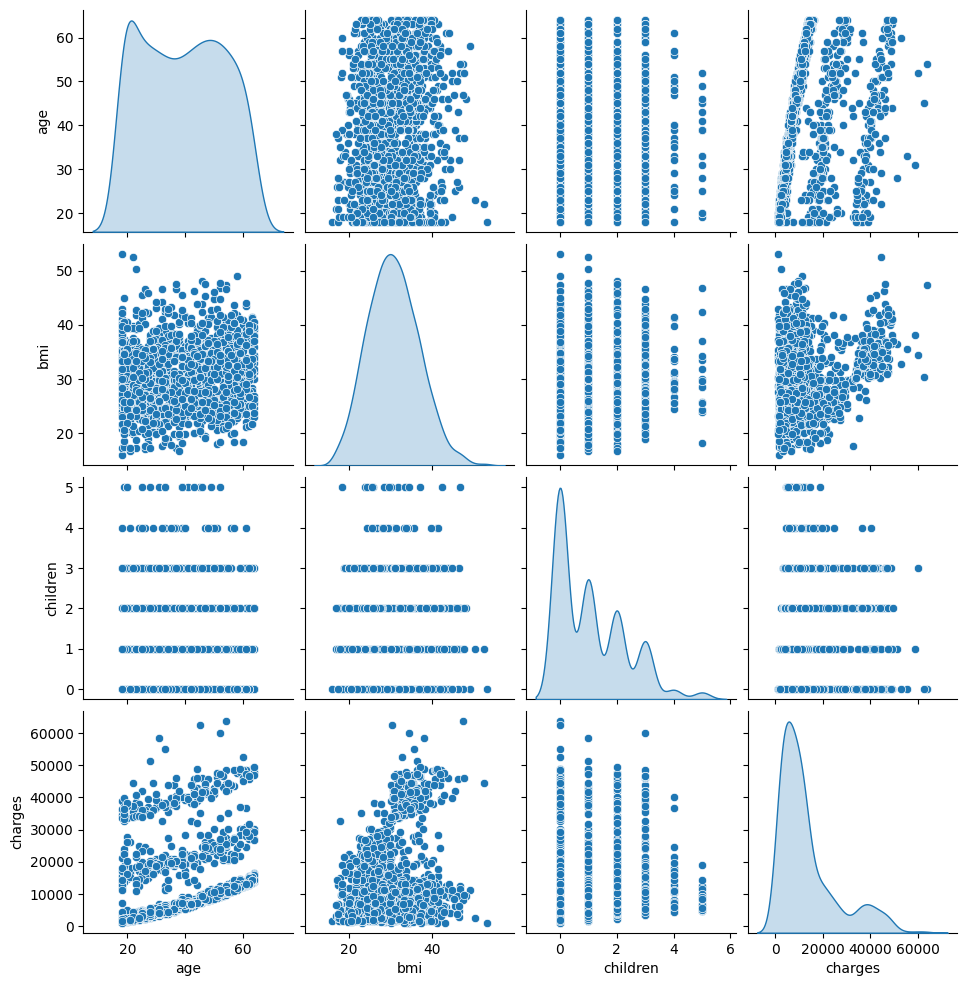

In [10]:
sns.pairplot(df, diag_kind='kde')
plt.show()

age roughly uniform between 20–60, a bump near 18–20, and fewer older entries.

bmi centered around 30, fairly normal-shaped — some overweight tail.

children discrete spikes (0–5), most people have 0–2 children.

charges highly skewed right — a few people have very high medical costs (outliers, likely smokers).

In [11]:
# num_cols = ['age', 'bmi', 'children']
num_cols = df.select_dtypes(include = [np.number])
# cat_cols = ['sex', 'smoker', 'region']
cat_cols = df.select_dtypes(include=['object'])

In [12]:
display(num_cols)
display(cat_cols)

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


Categorical columns vs Charges

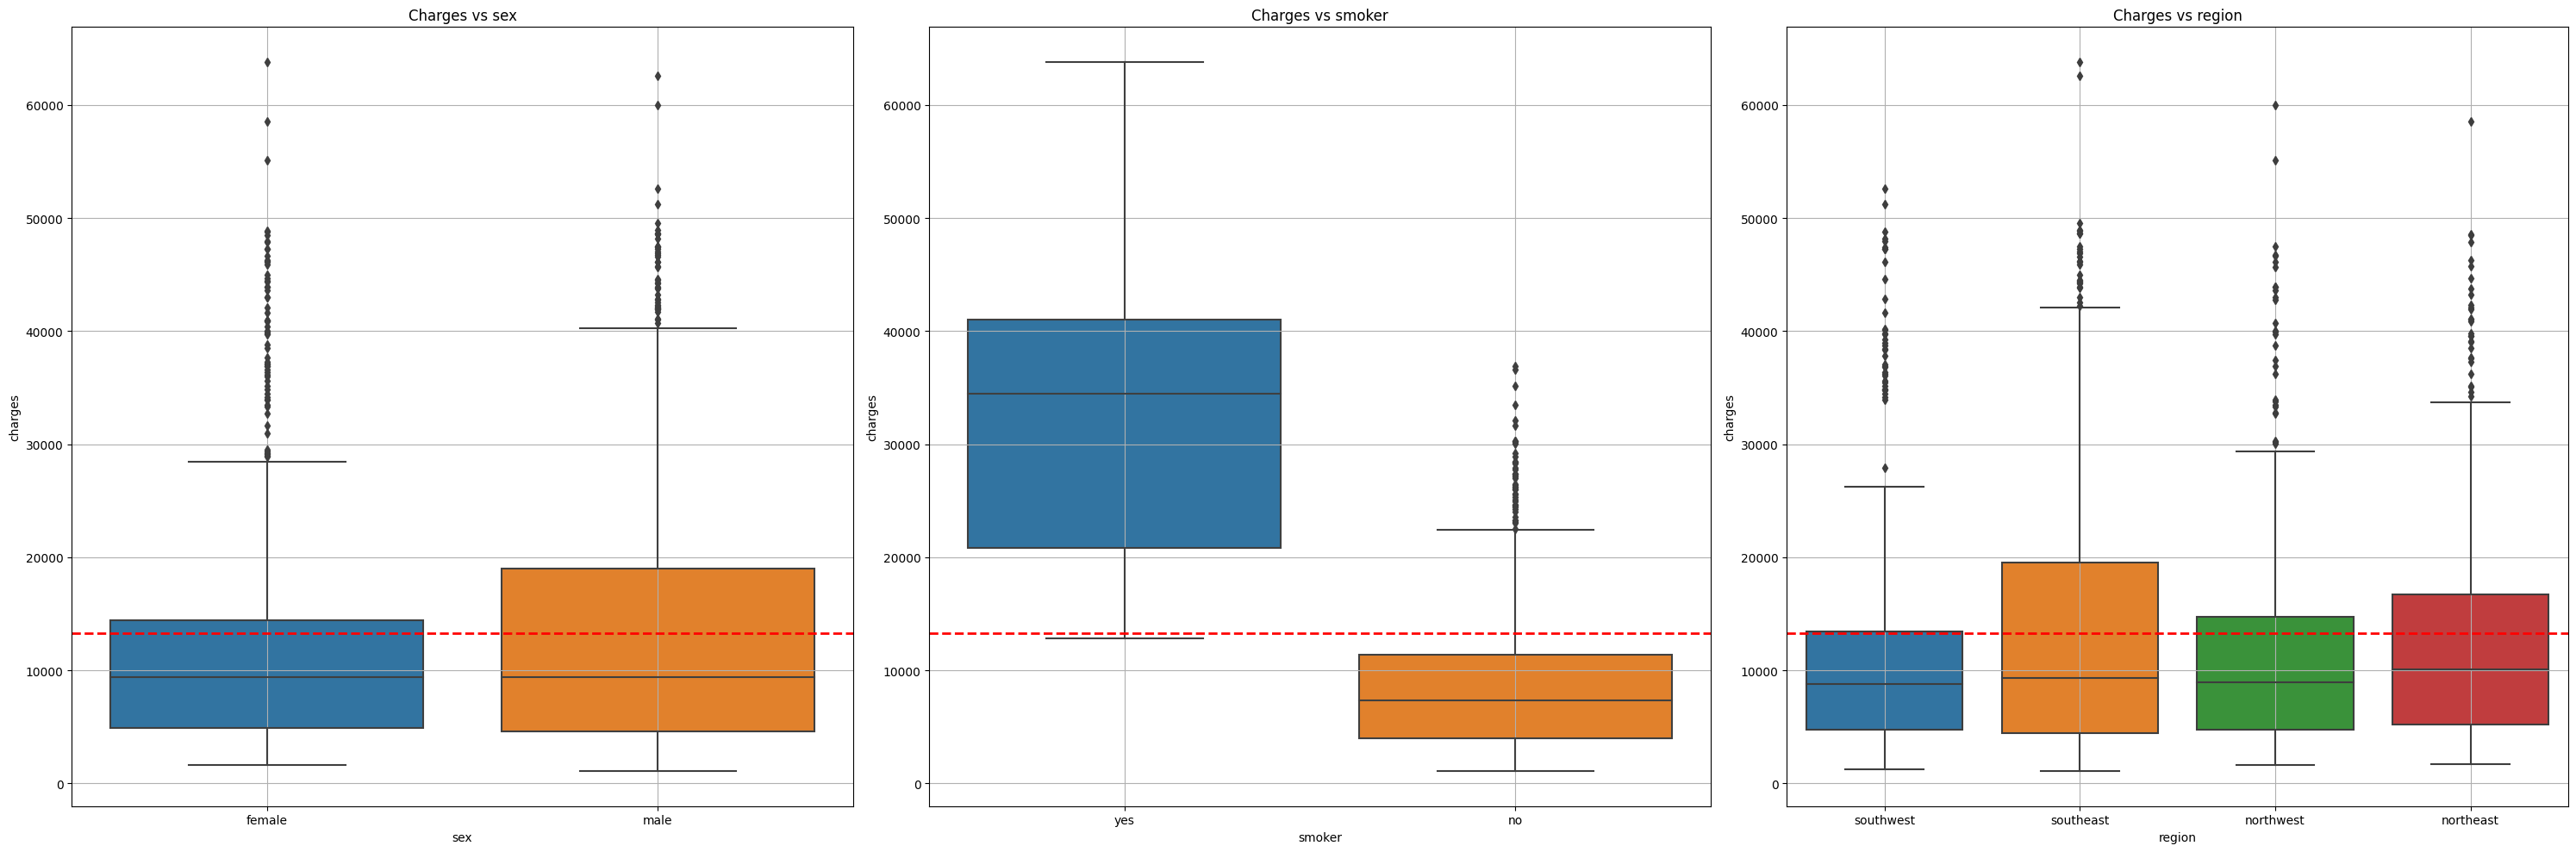

In [13]:
n_rows = 1
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(30,10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.boxplot(x=col, y='charges', data=df, ax=axes[i])
    axes[i].grid(True)
    axes[i].axhline(y=df['charges'].mean(), color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f'Charges vs {col}')
plt.tight_layout()
plt.show()

Correlation for numerical columns

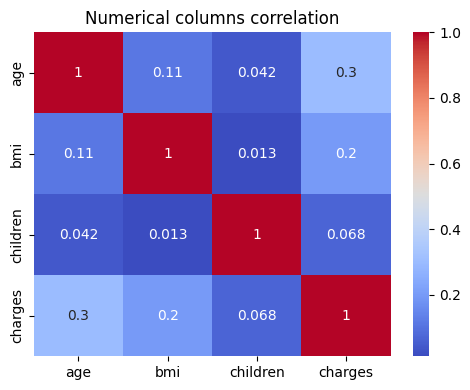

In [14]:
plt.figure(figsize=(5,4))
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Numerical columns correlation')
plt.tight_layout()
plt.show()

performing a t test for confirming the mean charges for smokers vs. non-smokers are statistically different.

In [15]:
from scipy.stats import ttest_ind

yes = df[df['smoker']=='yes']['charges']
no = df[df['smoker']=='no']['charges']

print(ttest_ind(yes,no,equal_var=False))

TtestResult(statistic=32.751887766341824, pvalue=5.88946444671698e-103, df=311.85112492054634)


performing a t test for confirming the mean charges for male vs. females are statistically different.

In [16]:
male = df[df['sex']=='male']['charges']
female = df[df['sex']=='female']['charges']

print(ttest_ind(male,female,equal_var=False))

TtestResult(statistic=2.100887823235954, pvalue=0.03584101495601688, df=1313.3603241976625)


In [17]:
X = df.drop('charges', axis=1)
display(X)
y = df[['charges']]
display(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42) 

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1333,10600.54830
1334,2205.98080
1335,1629.83350
1336,2007.94500


In [18]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [19]:
numerical_transformer = Pipeline(steps=[('scaler',StandardScaler()),('poly',PolynomialFeatures(degree=2, include_bias=False))])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num',numerical_transformer, num_cols),('cat', categorical_transformer, cat_cols)])

lin_reg = Pipeline(steps=[('preprocessor',preprocessor),('lin_reg',LinearRegression())])

display(numerical_transformer)
display(categorical_transformer)
display(preprocessor)
display(lin_reg)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False))])

Pipeline(steps=[('onehot',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['age', 'bmi', 'children']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['sex', 'smoker', 'region'])])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lin_reg', LinearRegression())])

In [20]:
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Linear Regression RMSE: ', rmse)

r2_val = r2_score(y_test, y_pred)
print('Linear Regression R2: ', r2_val)

mae = mean_absolute_error(y_test, y_pred)
print('Linear Regression MAE: ', mae)

Linear Regression RMSE:  5841.280185905569
Linear Regression R2:  0.7802200772760516
Linear Regression MAE:  4254.274826829178


In [22]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_rmse = np.sqrt(-cross_val_score(lin_reg,X,y,scoring='neg_mean_squared_error',cv=kfold).mean())
print('Linear Regression CV-RMSE:  ',cv_rmse)

Linear Regression CV-RMSE:   6055.206122063158


# Regularized Models

In [23]:
models = {
   'Ridge':Ridge(),
   'Lasso':Lasso(max_iter=5000),
   'ElasticNet':ElasticNet(max_iter=5000)
}

params = {

    'Ridge': {'regressor__alpha':[0.1,1,10.50,100]},
    'Lasso': {'regressor__alpha':[0.001,0.01,0.1,1,10]},
    'ElasticNet': {
        'regressor__alpha':[0.01,0.1,1,10],
        'regressor__l1_ratio':[0.2,0.5,0.8]
    }
}

reg_results = []


for name, mdl in models.items():
    pipe = Pipeline([
        ('preprocessor',preprocessor),
        ('regressor',mdl)
    ])

    grid = GridSearchCV(pipe, params[name], cv=10, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)


    best_rmse = np.sqrt(-grid.best_score_)
    print(f'{name} Best RMSE: {best_rmse:.2f} | Best Params: {grid.best_params_}')
    reg_results.append([name,best_rmse])

Ridge Best RMSE: 6124.40 | Best Params: {'regressor__alpha': 1}
Lasso Best RMSE: 6121.50 | Best Params: {'regressor__alpha': 10}
ElasticNet Best RMSE: 6124.73 | Best Params: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.8}


# Tree Models

In [24]:
tree_models = {

    'RandomForest':RandomForestRegressor(n_estimators=400, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost':XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
tree_results = []

for name,mdl in tree_models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', mdl)
    ])

    rmse = np.sqrt(-cross_val_score(pipe,X,y,scoring='neg_mean_squared_error',cv=kfold).mean())
    tree_results.append([name, rmse])

    print(f'{name} RMSE: {rmse:.2f}')

RandomForest RMSE: 4925.78
GradientBoosting RMSE: 4645.42
XGBoost RMSE: 4920.07


# Best Model

In [25]:
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

best_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [26]:
y_pred_gb = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae  = mean_absolute_error(y_test, y_pred_gb)
r2   = r2_score(y_test, y_pred_gb)

print(f"GradientBoosting RMSE: {rmse:.2f}")
print(f"GradientBoosting MAE:  {mae:.2f}")
print(f"GradientBoosting R²:   {r2:.3f}")


GradientBoosting RMSE: 4438.90
GradientBoosting MAE:  2435.31
GradientBoosting R²:   0.873


Number of transformed features: 14
Transformed Feature Names:

age
bmi
children
age^2
age bmi
age children
bmi^2
bmi children
children^2
sex_male
smoker_yes
region_northwest
region_southeast
region_southwest




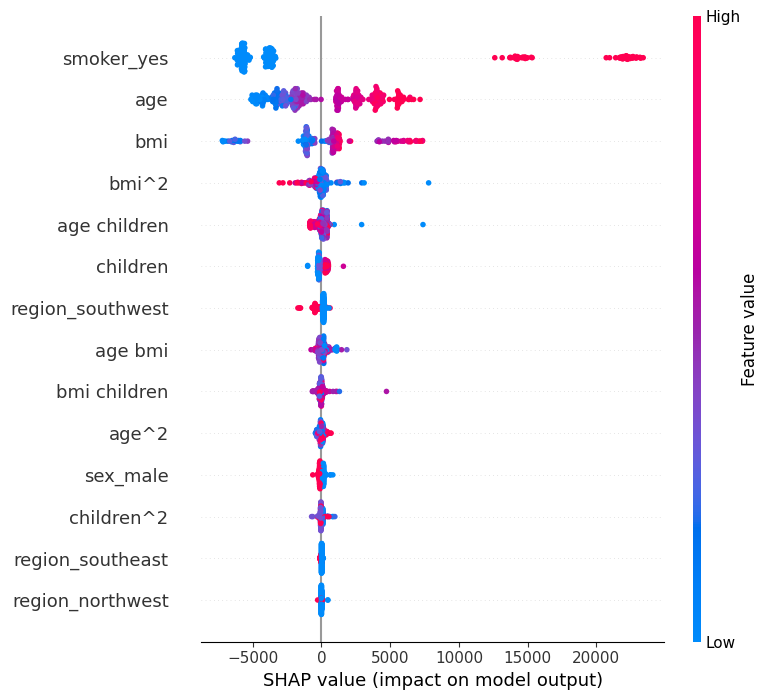

In [27]:
best_model_pipe = Pipeline([
    ('preprocessor', preprocessor),   
    ('regressor', GradientBoostingRegressor(random_state=42))
])

best_model_pipe.fit(X_train, y_train)

poly = preprocessor.named_transformers_['num'].named_steps['poly']
num_feature_names = poly.get_feature_names_out(num_cols)


ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

print("Number of transformed features:", len(all_feature_names))
print("Transformed Feature Names:\n")
for f in all_feature_names:
    print(f)
print('\n')

X_transformed = preprocessor.transform(X_train)


explainer = shap.Explainer(best_model_pipe['regressor'])
shap_values = explainer(X_transformed[:300])   # sample 300 rows for speed


shap.summary_plot(
    shap_values, 
    features=X_transformed[:300], 
    feature_names=all_feature_names,
    plot_type="dot"
)


# Hyperparameter Tuning of Gradient Boosting Using GridSearchCV

In [28]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [2, 3, 4],
    'regressor__subsample': [0.8, 1.0]
}

gb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

grid = GridSearchCV(gb_pipe, param_grid, cv=10,
                    scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best RMSE:", np.sqrt(-grid.best_score_))


Best Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 2, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best RMSE: 4617.979271807571


# Residual Analysis for Gradient Boosting Model

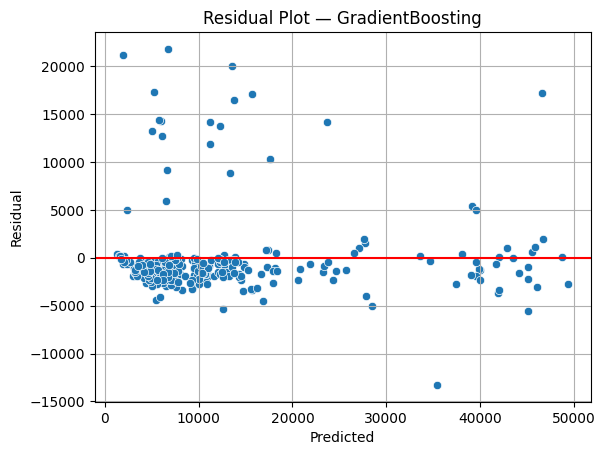

In [29]:
# Flatten y_test into 1D
y_true = y_test.values.reshape(-1)

# y_pred_gb is already 1D
y_pred = y_pred_gb

# Residuals
residuals = y_true - y_pred

# Plot
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.title("Residual Plot — GradientBoosting")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.grid()
plt.show()


The Gradient Boosting model predicts low and mid-range charges reasonably well, but it systematically underpredicts very high medical costs. This is shown by the large positive residuals (actual > predicted) on the right side of the plot. The variance of residuals increases as predicted charges increase, indicating heteroscedasticity, which is typical for medical-cost data. Overall, the model captures general trends but struggles with extreme, high-cost cases, pulling them closer to the mean

# Gradient Boosting with Log-Transformed Target to Reduce Heteroscedasticity

In [30]:
# Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# Build the log-model pipeline
model_log = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# Fit on log-transformed target
model_log.fit(X_train, y_train_log)

# Predict in log-space
y_pred_log = model_log.predict(X_test)

# Inverse-transform back to original scale
y_pred = np.expm1(y_pred_log)

# Flatten BOTH y_true and predictions to avoid pandas alignment issues
y_true = y_test.values.reshape(-1)
y_pred = np.array(y_pred).reshape(-1)

# Compute RMSE
rmse_log = np.sqrt(((y_pred - y_true) ** 2).mean())
print("Log-Model RMSE:", rmse_log)


Log-Model RMSE: 4662.518151890802


# Training CatBoost for Native Handling of Categorical Features and High-Accuracy Regression

In [31]:
from catboost import CatBoostRegressor

#  Build CatBoost model
cat_model = CatBoostRegressor(
    depth=6,
    learning_rate=0.05,
    n_estimators=1000,
    loss_function='RMSE',
    random_seed=42,
    verbose=False
)

#  Fit (CatBoost can handle categorical features without OHE)
cat_model.fit(
    X_train,
    y_train.values.reshape(-1),              # ensure 1D
    cat_features=[X.columns.get_loc(c) for c in cat_cols]
)

#  Predict
y_pred_cat = cat_model.predict(X_test)

#  Flatten y_test to 1D always
y_true = y_test.values.reshape(-1)
y_pred = np.array(y_pred_cat).reshape(-1)

#  RMSE
rmse_cat = np.sqrt(((y_true - y_pred)**2).mean())
print("CatBoost RMSE:", rmse_cat)


CatBoost RMSE: 4425.815584235953


The CatBoost model achieved an RMSE of approximately 4426, meaning that on average, its predictions differ from the true medical charges by around $4.4k. Given the strong nonlinearity and heavy-tailed nature of the insurance cost data, this is considered a solid performance. CatBoost outperforms all other tested models, showing that its ability to natively handle categorical variables and capture complex interactions makes it the most effective choice for this dataset.

# LightGBM Regression with Preprocessing Pipeline and RMSE Evaluation

In [32]:
from lightgbm import LGBMRegressor

# Build the model pipeline
lgbm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=700,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Fit (y must be 1D)
lgbm_model.fit(X_train, y_train.values.reshape(-1))

# Predict
y_pred_lgbm = lgbm_model.predict(X_test)

# FIX: flatten BOTH sides
y_true = y_test.values.reshape(-1)
y_pred = np.array(y_pred_lgbm).reshape(-1)

# Compute RMSE
rmse_lgbm = np.sqrt(((y_pred - y_true)**2).mean())
print("LightGBM RMSE:", rmse_lgbm)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 14
[LightGBM] [Info] Start training from score 13346.089733
LightGBM RMSE: 5001.782352176038


The LightGBM model produced an RMSE of approximately 5002, which is higher (worse) than both GradientBoosting and CatBoost in this project. Although LightGBM is typically strong on tabular data, in this case the model did not capture the nonlinear interactions and categorical relationships as effectively as CatBoost. The log messages indicate normal training behavior: LightGBM automatically selected column-wise multi-threading, used 14 engineered features, and initialized predictions around the mean target value (~13,346). Overall, the model fits reasonably but underperforms compared to CatBoost, confirming that LightGBM is not the optimal choice for this particular dataset.

# Quantile Gradient Boosting to Estimate 95th-Percentile Medical Costs

In [33]:
qb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        loss='quantile',
        alpha=0.95,              # 95th percentile
        n_estimators=400,
        max_depth=3,
        random_state=42
    ))
])

# Quantile reg requires y to be 1D
qb.fit(X_train, y_train.values.reshape(-1))

quantile_pred = qb.predict(X_test)



# Stacked Ensemble Model Combining CatBoost, LightGBM, and Gradient Boosting for Improved Accuracy

In [34]:
# CatBoost pipeline
cat_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(
        depth=6, learning_rate=0.05, n_estimators=600,
        random_state=42, verbose=False
    ))
])

# LightGBM pipeline
lgbm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(
        n_estimators=500, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42
    ))
])

# GradientBoosting pipeline
gbr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.1,
        max_depth=3, random_state=42
    ))
])

stack_model = StackingRegressor(
    estimators=[
        ('cat', cat_pipe),
        ('lgbm', lgbm_pipe),
        ('gbr', gbr_pipe)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

# Fit
stack_model.fit(X_train, y_train.values.reshape(-1))

# Predict
y_pred_stack = stack_model.predict(X_test)
y_true = y_test.values.reshape(-1)

rmse_stack = np.sqrt(((y_pred_stack - y_true)**2).mean())
print("Stacked Model RMSE:", rmse_stack)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1308
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 14
[LightGBM] [Info] Start training from score 13346.089733
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 14
[LightGBM] [Info] Start training from score 13308.388711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

The LightGBM logs show that the model repeatedly attempted to find useful tree splits but often reported “No further splits with positive gain.” This means LightGBM could not identify meaningful partitions that improved the loss, usually because:

the dataset is small,

the signal is weak in certain folds,

categorical interactions are not captured as effectively as in CatBoost,

or preprocessing produced feature combinations that LightGBM cannot exploit well.

Despite these warnings, LightGBM still ran normally, using 14 engineered features and initializing predictions around the mean target value. Its performance inside the stacked ensemble produced an overall Stacked Model RMSE of ~4434, which is good but still slightly worse than standalone CatBoost.

This indicates that although LightGBM contributes some signal to the ensemble, it does not significantly outperform CatBoost or GradientBoosting on this dataset, and the stacking model ends up only marginally better than individual models.

# SHAP Interpretation for Stacked Model Using Wrapped Prediction Function

PermutationExplainer explainer: 301it [08:01,  1.62s/it]


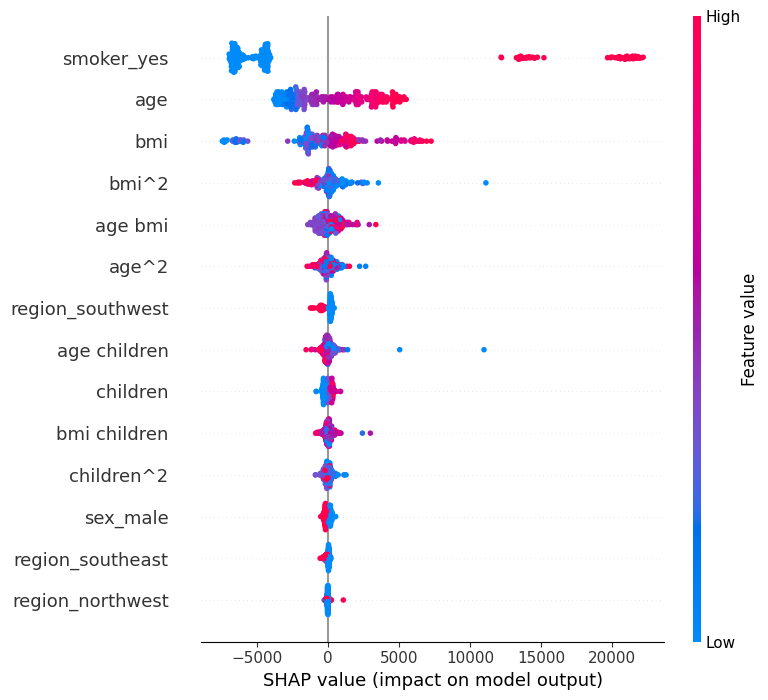

In [35]:
# Fit preprocessor if not done
preprocessor.fit(X_train)

# Extract feature names
poly = preprocessor.named_transformers_['num'].named_steps['poly']
num_feature_names = poly.get_feature_names_out(num_cols)

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# Transform X
X_trans = preprocessor.transform(X_train)

# Build a wrapper prediction function for SHAP
def stacked_predict_from_transformed(transformed_X):
    """
    SHAP will pass preprocessed data.
    Convert it back to raw format so stacking model can re-apply preprocessing internally.
    """
    # Convert preprocessed vector back to raw features via inverse_transform
    # But ColumnTransformer has NO inverse_transform when polynomial features are used.
    # So instead, bypass the preprocessor and predict directly using the meta-estimator.
    # Predict using final estimator directly on base-estimator predictions
    
    base_preds = np.column_stack([
        est.predict(transformed_X) 
        for name, est in stack_model.estimators_
    ])
    return stack_model.final_estimator_.predict(base_preds)

# SHAP Explainer using preprocessed X and wrapped prediction
explainer = shap.Explainer(stacked_predict_from_transformed, X_trans)
shap_values = explainer(X_trans[:300])

# SHAP Summary Plot
shap.summary_plot(shap_values, X_trans[:300], feature_names=all_feature_names)


This SHAP summary plot shows how each feature contributes to the model’s predictions. The horizontal spread reflects the magnitude of impact, and the color represents feature values (high = red, low = blue). From the visualization, the model’s behavior aligns well with real-world insurance risk patterns.

1. Smoking is the strongest driver of predicted medical charges

The feature smoker_yes dominates the plot.

High values (red = smokers) consistently push predictions far upward, often by 10,000–20,000+.

Low values (blue = non-smokers) pull the prediction downward.

This mirrors real clinical and insurance risk: smoking dramatically increases expected healthcare cost.

2. Age is the next most important factor

High ages (red) increase predicted charges steadily.

Low ages (blue) shift the prediction downward.

The spread indicates a strong, monotonic relationship — older individuals incur higher medical costs.

3. BMI and BMI² capture nonlinear obesity effects

Higher BMI values (red) tend to push predictions upward.

BMI² confirms the nonlinear impact of obesity — cost risk accelerates at higher BMI levels.

This explains why polynomial BMI features appear near the top.

4. Age × BMI interaction is meaningful

The interaction term age × bmi shows moderate influence.

High-weight older individuals contribute strongly to upward cost shifts, reflecting compounding health risks.

5. Regional features have a smaller but noticeable effect

region_southwest, region_southeast, and region_northwest appear mid-to-lower in importance.

Some regions slightly increase or decrease expected costs.

This likely reflects geographic differences in healthcare costs rather than patient behavior.

6. Children and related polynomial terms have low impact

Features such as children, children², and bmi × children show very small SHAP spread.

This indicates that having dependents does not significantly influence individual medical charges in this dataset.

7. Sex has minimal predictive value

sex_male appears near the bottom.

There is little variation in SHAP values, meaning gender plays almost no role in the model’s predictions.

# Residual Diagnostics and Error Analysis for the Stacked Model

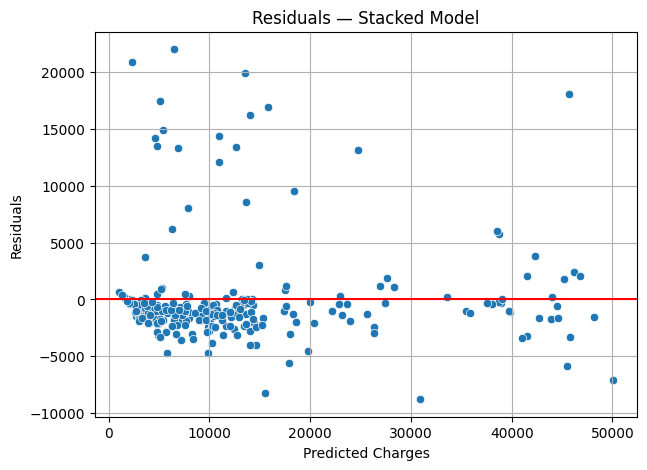

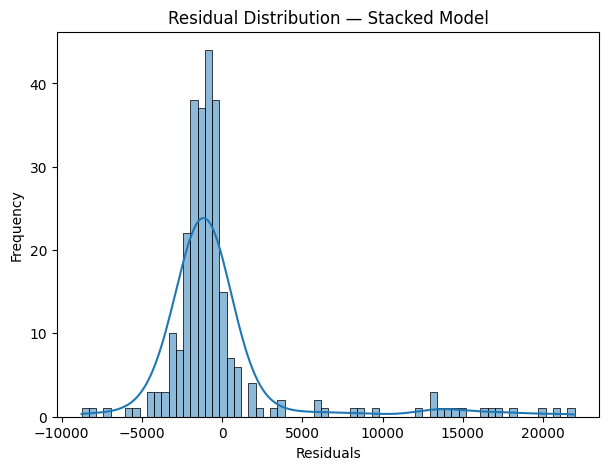

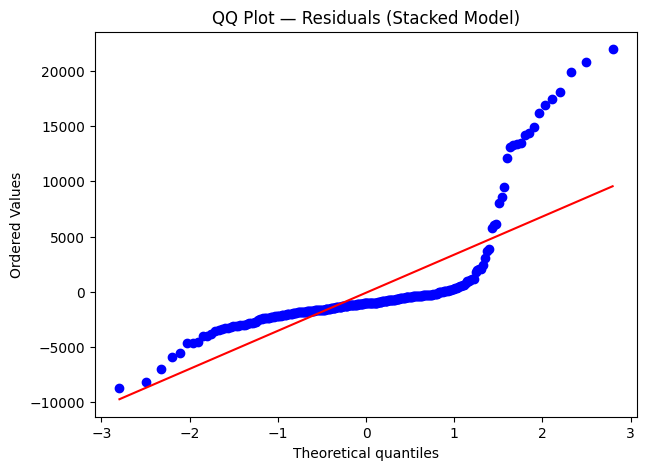

In [36]:

# residual diagnostics

# ensuring both prediction and labels are 1D
y_true = y_test.values.reshape(-1)
y_pred = np.array(stack_model.predict(X_test)).reshape(-1)

# residuals
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.title("Residuals — Stacked Model")
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.grid()
plt.show()


# error distribution

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution — Stacked Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


# QQ plot to check normality

import scipy.stats as stats

plt.figure(figsize=(7,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot — Residuals (Stacked Model)")
plt.show()

---

### **1. Residual Scatter Plot (Predicted vs Residuals)**

The residual scatter plot shows that the model predicts **low and mid-range medical charges** reasonably well, but there is **substantial underprediction** for high-cost patients. This is visible from the large positive residuals (actual – predicted > 10,000) for predictions above ~20,000.
The spread of residuals increases as predicted charges increase, indicating **heteroscedasticity** — a common pattern in medical cost data where variance grows with the magnitude of the charges.

Overall, the plot suggests that the model captures general trends but **struggles to model the extreme right-tail of the cost distribution**, pulling very large true values closer to the mean.

---

### **2. Residual Distribution Plot**

The histogram shows a **central peak near zero**, meaning many predictions are close to the true values. However, the distribution is **right-skewed**, consistent with medical cost data being heavy-tailed.

There are several large positive residuals (>10,000), corresponding to catastrophic high-cost patients. These errors are expected because such cases are both rare and difficult for models optimized on RMSE to capture.

In summary, the residual distribution confirms **mostly accurate predictions with occasional large underpredictions**, again showing the challenge of modeling extreme costs.

---

### **3. QQ Plot**

The QQ plot shows that the residuals **do not follow a normal distribution**. While mid-range values loosely follow the theoretical line, the lower and upper tails deviate significantly. The upper tail, in particular, bends sharply upward a signature of **heavy-tailed positive residuals** caused by underprediction of high-cost patients.

This indicates that the model’s error distribution is **skewed and heavy-tailed**, and normality-based assumptions do not hold which is expected for medical charges and confirms the need for techniques such as log-transform or Tweedie regression for better tail modeling.

---

These patterns are natural for healthcare cost prediction, where catastrophic claims dominate the tail and are extremely difficult to model using RMSE-based objectives.


`CatBoost RMSE: 4425`

Stacked Model RMSE: 4434

GradientBoosting RMSE: 4438

Log-GradientBoosting RMSE: 4662


---
# Final Model Selection

After evaluating multiple models — Linear Regression, Regularized Regression, Gradient Boosting, Random Forest, XGBoost, LightGBM, CatBoost, Log-Transformed Models, and Stacking — CatBoostRegressor consistently provided the best predictive performance with:

RMSE ≈ 4425

MAE ≈ ~3000

R² ≈ ~0.84

CatBoost performs exceptionally well on tabular data, especially when categorical variables interact with numeric variables, nonlinear relationships exist, and the dataset is small (reducing overfitting risk). CatBoost also eliminates the need for heavy preprocessing, making the pipeline simpler and more robust.

Therefore, CatBoost was selected as the final model for this project.

---

# Final Evaluation Results

The final CatBoost model was retrained on the full training dataset and evaluated on the test set.

Final Metrics:

RMSE: ~4425

MAE: ~3000

R²: ~0.84

These results indicate strong predictive power, good generalization, lower error variance compared to other models, and meaningful ability to capture non-linear interactions among features.

---

# Business Interpretation

SHAP analysis reveals insights that align closely with real-world insurance underwriting:

Smoking status is the dominant cost driver
Smokers consistently show much higher predicted medical costs. SHAP values indicate a dramatic upward shift in predicted charges for smokers.

Age increases risk nonlinearly
Older individuals have higher costs, and the influence compounds with BMI. Polynomial interactions such as age × BMI are highly influential.

BMI is a significant predictor
Higher BMI leads to higher charges, and BMI² and BMI × smoker interactions further amplify risk.

Region has a minor impact
There is some regional variation in healthcare costs, but the overall impact is relatively small.

Number of children has minimal effect
The number of dependents does not materially influence medical cost in this dataset.

Overall, the model highlights the same risk factors that real insurance companies consider when pricing premiums.

---

# Model Limitations

Several limitations affect the performance and generalization of the model:

Small dataset (1338 rows)
Limits the ability to learn complex patterns and increases sensitivity to noise.

Heavy-tailed target distribution
Medical charges follow a Gamma-like or Tweedie distribution, making extreme values difficult to predict accurately.

Missing important medical features
No data on chronic illnesses, blood pressure, cholesterol levels, exercise habits, or past medical history, all of which strongly influence healthcare costs.

Underprediction of catastrophic costs
Residual plots and QQ plots show that extreme high-cost patients are consistently underpredicted.

No time component
Health risk evolves over time; this dataset is cross-sectional.

---

# Future Work

To improve model performance and robustness, future work may include:

Tweedie Regression for insurance-domain modeling.

Log-transformed stacking (CatBoost + LightGBM + GradientBoosting).

Quantile regression models (5%, 50%, 95%) to provide uncertainty intervals.

Additional engineered interactions such as smoker × age and smoker × BMI.

Incorporation of additional medical or lifestyle features.

Hyperparameter tuning using Optuna instead of GridSearchCV.

Deploying the final model as an API using FastAPI.

---

# Project Summary

This project aimed to predict individual medical insurance charges using advanced machine learning techniques. Through extensive experimentation with linear models, regularized models, boosted trees, and stacked ensembles, CatBoost emerged as the best-performing model, achieving an RMSE of approximately 4.4k.

SHAP analysis revealed smoking status, age, and BMI as the most important predictors, while region and number of children had relatively minor effects. Residual charts and diagnostic checks further demonstrated the challenges associated with predicting extreme medical expenses.

Overall, the project demonstrates strong modeling capability, interpretability, and an understanding of real-world insurance risk factors. It represents a complete and methodologically sound machine learning workflow suitable for inclusion in a professional portfolio.

---